### Import libraries

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
import tensorflow as tf
import matplotlib.pyplot as plt

### Setup

In [14]:
strategy = tf.distribute.get_strategy()

print("Number of replicas: {0}".format(strategy.num_replicas_in_sync))
print("TF version: {0}".format(tf.__version__))

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Starting batch size: 16
# Starting epoch: 100
# IMAGE SIZE: 176 * 208
# 이 값들은 차후적으로 튜닝을 진행하면서 변화할 예정
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

Number of replicas: 1
TF version: 2.3.0


### Load data

In [15]:
# 경증 치매, 중증도 치매, 비 치매, 매우 경미한 치매
CLASS_NAMES = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
NUM_CLASSES = len(CLASS_NAMES)

In [16]:
# 데이터셋의 label별로 나누어져 저장되어 있다.
# 즉, 이미 사전적으로 분류되어 있는 데이터셋이기에
# tf.keras의 전처리 기능을 이용해서 이미지를 loading
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/train",
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
train_ds.class_names = CLASS_NAMES

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/train",
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
val_ds.class_names = CLASS_NAMES

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


### Data visualize

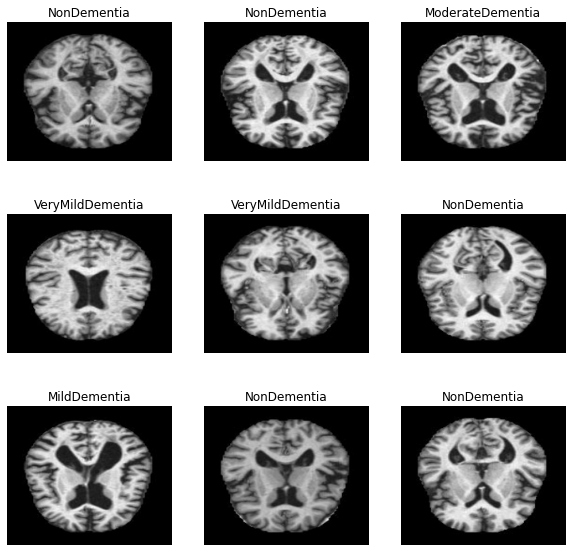

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

img_save_path = "./img/"
try:
    if not(os.path.isdir(img_save_path)):
        os.makedirs(os.path.join(img_save_path))

    plt.savefig(img_save_path + "train_data_visualize.png", facecolor="#eeeeee", bbox_inches="tight")
    plt.show()
except:
    print("[Failed to create directory]")

### Feature engineering

In [18]:
@tf.autograph.experimental.do_not_convert
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [7]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Build model

In [9]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.6),
        
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])
    
    return model

In [12]:
with strategy.scope():
    model = build_model()
    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer="adam",
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 176, 208, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 176, 208, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 88, 104, 16)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 88, 104, 32)       4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 88, 104, 32)       9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 88, 104, 32)       128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 44, 52, 32)       

### Training the Model

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

In [15]:
exponential_decay_fn = exponential_decay(0.01, 20)

In [16]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./model/alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 56/257 [=====>........................] - ETA: 10s - loss: 1.4406 - auc: 0.66

limit_output extension: Maximum message size of 10000 exceeded with 10039 characters

### Visualize Model Metrics

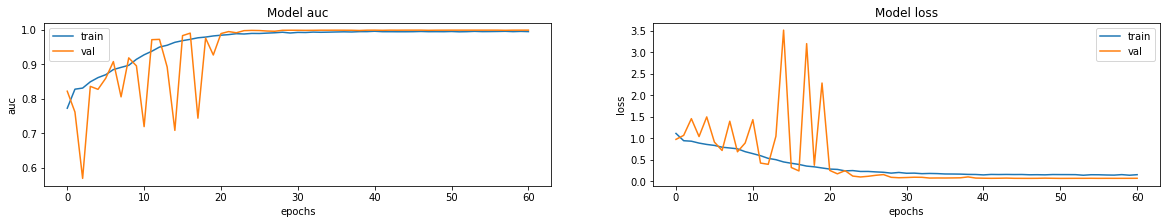

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

try:
    if not(os.path.isdir(img_save_path)):
        os.makedirs(os.path.join(img_save_path))

    plt.savefig(img_save_path + "AICAv1_acc_loss.png", facecolor="#eeeeee", bbox_inches="tight")
    plt.show()
except:
    print("[Failed to create directory]")

### Evaluate the Model

In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 1279 files belonging to 4 classes.


In [20]:
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
test_history = model.evaluate(test_ds)

NameError: name 'model' is not defined

### Save the Model

In [25]:
model.save("AICAv1.h5")